## Part 0: Setup
In this part we set up some basic environment and variables needed for this project.

In [1]:
import os
import re
import bs4
import math
import requests
import warnings
import numpy as np
import pandas as pd
import keplergl as kg
from scipy import stats
import sqlalchemy as db
import geopandas as gpd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
# Variables needed
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
UBER_CSV = "uber_rides_sample.csv"
WEATHER_CSV = ["weather-2009.csv", "weather-2010.csv", "weather-2011.csv", 
               "weather-2012.csv", "weather-2013.csv", "weather-2014.csv", "weather-2015.csv"]
ZONE_PATH = "taxi_zones.shp"

NY_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE = "sqlite:///project.db"
SCHEMA_FILE = "schema.sql"

In [3]:
Taxi_zone = gpd.read_file(ZONE_PATH)
Taxi_zone = Taxi_zone.to_crs(4326)
Taxi_zone['longitude'] = Taxi_zone.centroid.x  
Taxi_zone['latitude'] = Taxi_zone.centroid.y

## Part 1: Data Preprocessing
### Yellow Taxi trip data: Downloading, Cleaning, Sampling

In [4]:
def get_taxi_html() -> bytes:
    response = requests.get(TAXI_URL)
    html = response.content
    return html

In [5]:
def find_taxi_parquet_links() -> list:
    links = []
    pattern = r"yellow_tripdata_2009|yellow_tripdata_201[0-4]|yellow_tripdata_2015-0[1-6]"
    soup = bs4.BeautifulSoup(get_taxi_html(),'html.parser')
    for a in soup.find_all("a",href = True):
        link_text = a.get("href")
        matches = re.findall(pattern,link_text)
        if matches:
            links.append(link_text)
    return links

In [6]:
def monthly_taxi_data_download_clean_sample(url: str) -> pd.core.frame.DataFrame:
    parquet_name = url.split("/")[-1]

    # download if it doesn't exist
    if not os.path.exists(parquet_name):
        print(f"Downloading parquet for {parquet_name[16:23]}.")
        file = requests.get(url)
        with open(parquet_name , "wb") as f:
            f.write(file.content)
    
    # load data from parquet file
    data = pd.read_parquet(parquet_name)
    print(f"Cleaning data for {parquet_name[16:23]}.")
    
    # 为了不占用太多内存，读一个删一个，最后提交之前要删掉
    os.remove(parquet_name) 
    print(f"Parquet for {parquet_name[16:23]} is removed.")
    
    # looking up the latitude and longitude for some months where only location IDs are given for pickups and dropoffs
    # keep NaNs if exists
    if "PULocationID" in data.columns:
        data["pickup_latitude"] = data["PULocationID"].map(Taxi_zone["latitude"], na_action = "ignore")
        data["pickup_longitude"] = data["PULocationID"].map(Taxi_zone["longitude"], na_action = "ignore")
        data["dropoff_latitude"] = data["DOLocationID"].map(Taxi_zone["latitude"], na_action = "ignore")
        data["dropoff_longitude"] = data["DOLocationID"].map(Taxi_zone["longitude"], na_action = "ignore")
    
    # normalize column names
    rename_dict = {
        "VendorID" : "vendor_id",
        "tpep_pickup_datetime" : "pickup_datetime",
        "tpep_dropoff_datetime" : "dropoff_datetime",
        "RatecodeID" : "rate_code",
        "Trip_Pickup_DateTime" : "pickup_datetime",
        "Trip_Dropoff_DateTime" : "dropoff_datetime",
        "Start_Lon" : "pickup_longitude",
        "Start_Lat" : "pickup_latitude",
        "End_Lon" : "dropoff_longitude",
        "End_Lat" : "dropoff_latitude",
        "Fare_Amt" : "fare_amount",
        "Tip_Amt" : "tip_amount",
        "Tolls_Amt" : "tolls_amount",
        "Total_Amt" : "total_amount"
    }
    data.rename(columns = rename_dict, inplace = True)
    
    # remove the trips that the location IDs are be valid
    data.dropna(subset=["pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude"],inplace = True)
    
    # remove invalid data points
    data = data[data["total_amount"] > 0]
    
    # normalize and use appropriate column types for the respective data
    data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"])
    data["dropoff_datetime"] = pd.to_datetime(data["dropoff_datetime"])
    data = data.astype({"pickup_latitude": "float64","pickup_longitude": "float64",\
                        "dropoff_latitude": "float64","dropoff_longitude": "float64","tip_amount": "float64"})
    
    # remove unnecessary columns and only keeping columns needed
    data = data[["pickup_datetime","pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude","tip_amount"]]
    
    # remove trips that start and/or end outside of NY
    data = data[(data["pickup_latitude"] >= NY_COORDS[0][0]) & (data["pickup_latitude"] <= NY_COORDS[1][0])]
    data = data[(data["pickup_longitude"] >= NY_COORDS[0][1]) & (data["pickup_longitude"] <= NY_COORDS[1][1])]
    data = data[(data["dropoff_latitude"] >= NY_COORDS[0][0]) & (data["dropoff_latitude"] <= NY_COORDS[1][0])]
    data = data[(data["dropoff_longitude"] >= NY_COORDS[0][1]) & (data["dropoff_longitude"] <= NY_COORDS[1][1])]
    
    # Sampling
    # Uber dataset consists of 200000 data points
    # Therefore, we need 200000/78 ~ 2564 data points from each month
    data = data.sample(2564)

    return data


### Yellow Taxi trip data: Filling (Distance)

We calculate the distance between pickup location and dropoff location using the Haversine Formula:

![](https://user-images.githubusercontent.com/2789198/27240436-e9a459da-52d4-11e7-8f84-f96d0b312859.png)

where $\lambda$ and $\phi$ are the `longitude` and `latitude` of locations respectively, $r$ is the radius of earth.

In [7]:
def calculate_distance(pu_coord: pd.core.frame.DataFrame, do_coord: pd.core.frame.DataFrame) -> pd.core.series.Series:
    
    pick_lon = pu_coord["pickup_longitude"].map(math.radians)
    pick_lat = pu_coord["pickup_latitude"].map(math.radians)
    drop_lon = do_coord["dropoff_longitude"].map(math.radians)
    drop_lat = do_coord["dropoff_latitude"].map(math.radians)
    
    delta_lat = drop_lat - pick_lat
    delta_lon = drop_lon - pick_lon
    
    # Take the average earth radius (km) as r
    r = 6371
    part_formula = ((delta_lat/2).map(math.sin))**2 + (pick_lat.map(math.cos))*(drop_lat.map(math.cos))*((delta_lon/2).map(math.sin))**2
    dist = 2 * r * part_formula.map(math.sqrt).map(math.asin)
    
    return dist.astype("float64")

In [8]:
def filling_distance(data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    pu_coord = data[["pickup_longitude","pickup_latitude"]]
    do_coord = data[["dropoff_longitude","dropoff_latitude"]]
    data["distance"] = calculate_distance(pu_coord, do_coord)
    
    return data

In [9]:
def all_taxi_data(urls: list) -> pd.core.frame.DataFrame:
    all_taxi_df = []
    for url in urls:
        data = monthly_taxi_data_download_clean_sample(url)
        data = filling_distance(data)
        all_taxi_df.append(data)
    
    all_data = pd.concat(all_taxi_df)
    
    return all_data

### Uber rides data: Reading, Cleaning and Filling

In [10]:
def uber_data_read_clean_fill() -> pd.core.frame.DataFrame:
    
    data = pd.read_csv(UBER_CSV, low_memory = False)
    print("Cleaning data for Uber rides.")
    
    # remove the trips that the location IDs are be valid
    data.dropna(subset=["pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude"],inplace = True)
    
    # normalize and use appropriate column types for the respective data
    data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"])
    data = data.astype({"pickup_latitude": "float64","pickup_longitude": "float64",\
                        "dropoff_latitude": "float64","dropoff_longitude": "float64"})
    
    # remove invalid data points
    data = data[data["fare_amount"] > 0]
    
    # remove unnecessary columns and only keeping columns needed 
    data = data[["pickup_datetime","pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude"]]
    
    # remove trips that start and/or end outside of NY
    data = data[(data["pickup_latitude"] >= NY_COORDS[0][0]) & (data["pickup_latitude"] <= NY_COORDS[1][0])]
    data = data[(data["pickup_longitude"] >= NY_COORDS[0][1]) & (data["pickup_longitude"] <= NY_COORDS[1][1])]
    data = data[(data["dropoff_latitude"] >= NY_COORDS[0][0]) & (data["dropoff_latitude"] <= NY_COORDS[1][0])]
    data = data[(data["dropoff_longitude"] >= NY_COORDS[0][1]) & (data["dropoff_longitude"] <= NY_COORDS[1][1])]
    
    # fill in distance column
    data = filling_distance(data)
    
    return data

### Weather data: Reading, Cleaning and Filling

In [11]:
def hourly_weather_data_read_clean_fill(csv: str) -> pd.core.frame.DataFrame:
    
    data = pd.read_csv(csv, low_memory = False)
    
    # remove columns of no use
    data = data[["DATE","HourlyWindSpeed","HourlyPrecipitation"]]

    # remove missing values for wind speed data
    data.dropna(subset=["HourlyWindSpeed"], inplace=True)

    # normalize and use appropriate column types for the respective data
    data["DATE"] = pd.to_datetime(data["DATE"])
    data["HourlyPrecipitation"] = pd.to_numeric(data["HourlyPrecipitation"], errors = "coerce")

    # fill 0 to NAs in the precipitation data
    data["HourlyPrecipitation"].fillna(0, inplace=True)
    data = data.astype({"HourlyWindSpeed":"float64", "HourlyPrecipitation":"float64"})

    return data

In [12]:
def daily_weather_data_read_clean_fill(csv: str) -> pd.core.frame.DataFrame:
    
    data = pd.read_csv(csv, low_memory = False)
    data["DATE"] = pd.to_datetime(data["DATE"])
    data["HourlyPrecipitation"] = pd.to_numeric(data["HourlyPrecipitation"], errors = "coerce")
    data["HourlyPrecipitation"].fillna(0, inplace = True)
    
    # Only take date into consideration now
    data["DATE"] = data["DATE"].dt.date
    data_daily = data.groupby(["DATE"],as_index = False).agg({"HourlyPrecipitation":"sum","HourlyWindSpeed":"mean"})
    data_daily.rename(columns = {"HourlyPrecipitation" : "Precipitation", "HourlyWindSpeed" : "WindSpeed"}, inplace = True)
    
    
    data_daily["WindSpeed"].round(2)
    data_daily["DATE"] = pd.to_datetime(data_daily["DATE"])
    data_daily = data_daily.astype({"WindSpeed":"float64", "Precipitation":"float64"})
    
    return data_daily

In [13]:
def daily_sun_data_read(csv: str) -> pd.core.frame.DataFrame:
    
    data = pd.read_csv(csv, low_memory = False)
    data["DATE"] = pd.to_datetime(data["DATE"]).dt.date
    data_sun = data.groupby(["DATE"], as_index = False).agg({"Sunrise":"first","Sunset":"first"})
    data_sun = data_sun.dropna()
    data_sun["DATE"] = pd.to_datetime(data_sun["DATE"])
    
    # use appropriate column types for the respective data
    data_sun = data_sun.astype({"Sunrise":"int32", "Sunset":"int32"})
    data_sun = data_sun.astype({"Sunrise":"string", "Sunset":"string"})
    
    return data_sun

In [14]:
def all_weather_data() -> pd.core.frame.DataFrame:
    
    hourly_data = []
    daily_data = []
    sun_data = []
    
    for csv in WEATHER_CSV:
        ho_data = hourly_weather_data_read_clean_fill(csv)
        da_data = daily_weather_data_read_clean_fill(csv)
        su_data = daily_sun_data_read(csv)
        
        # for year 2015, only need data for the first six month
        if csv == "weather-2015.csv":
            ho_data = ho_data[ho_data["DATE"].dt.month <= 6]
            da_data = da_data[da_data["DATE"].dt.month <= 6]
            su_data = su_data[su_data["DATE"].dt.month <= 6]
            
        hourly_data.append(ho_data)
        daily_data.append(da_data)
        sun_data.append(su_data)
    
    hour_data = pd.concat(hourly_data)
    day_data = pd.concat(daily_data)
    day_sun_data = pd.concat(sun_data)
    
    return hour_data, day_data, day_sun_data

### Process all datasets

In [15]:
hourly_weather_data, daily_weather_data, daily_sun_data = all_weather_data()

In [16]:
uber_data = uber_data_read_clean_fill()

Cleaning data for Uber rides.


In [17]:
links = find_taxi_parquet_links()
taxi_data = all_taxi_data(links) # 加了个范围

Cleaning data for 2015-01.
Parquet for 2015-01 is removed.
Cleaning data for 2015-02.
Parquet for 2015-02 is removed.
Cleaning data for 2015-03.
Parquet for 2015-03 is removed.
Cleaning data for 2015-04.
Parquet for 2015-04 is removed.
Cleaning data for 2015-05.
Parquet for 2015-05 is removed.
Cleaning data for 2015-06.
Parquet for 2015-06 is removed.
Cleaning data for 2014-01.
Parquet for 2014-01 is removed.
Cleaning data for 2014-02.
Parquet for 2014-02 is removed.
Cleaning data for 2014-03.
Parquet for 2014-03 is removed.
Cleaning data for 2014-04.
Parquet for 2014-04 is removed.
Cleaning data for 2014-05.
Parquet for 2014-05 is removed.
Cleaning data for 2014-06.
Parquet for 2014-06 is removed.
Cleaning data for 2014-07.
Parquet for 2014-07 is removed.
Cleaning data for 2014-08.
Parquet for 2014-08 is removed.
Cleaning data for 2014-09.
Parquet for 2014-09 is removed.
Cleaning data for 2014-10.
Parquet for 2014-10 is removed.
Cleaning data for 2014-11.
Parquet for 2014-11 is remove

## Part 2: Storing Data
### Create database and tables

In [18]:
engine = db.create_engine(DATABASE)

In [19]:
# Define statements to create tables

Taxi_STMT = """
CREATE TABLE IF NOT EXISTS taxi_trip
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATE,
    pickup_latitude FLOAT64,
    pickup_longitude FLOAT64,
    dropoff_latitude FLOAT64,
    dropoff_longitude FLOAT64,
    tip_amount FLOAT64,
    distance FLOAT64
);
"""

Uber_STMT = """
CREATE TABLE IF NOT EXISTS uber_trip
(
    id INTEGER PRIMARY KEY,
    pickup_datetime DATE,
    pickup_latitude FLOAT64,
    pickup_longitude FLOAT64,
    dropoff_latitude FLOAT64,
    dropoff_longitude FLOAT64,
    distance FLOAT64
);
"""

Hourly_Weather_STMT = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY,
    DATE DATE,
    HourlyWindSpeed FLOAT64,
    HourlyPrecipitation FLOAT64
);
"""

Daily_Weather_STMT = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY,
    DATE DATE,
    Precipitation FLOAT64,
    WindSpeed FLOAT64
);
"""

Sun_STMT = """
CREATE TABLE IF NOT EXISTS daily_sun
(
    id INTEGER PRIMARY KEY,
    DATE DATE,
    Sunrise STRING,
    Sunset STRING
);
"""

In [20]:
with engine.connect() as connection:
    connection.execute(Taxi_STMT)
    connection.execute(Uber_STMT)
    connection.execute(Hourly_Weather_STMT)
    connection.execute(Daily_Weather_STMT)
    connection.execute(Sun_STMT)

### Add cleaned data to database

In [21]:
# add data from the dataframes to corresponding SQL tables
taxi_data.to_sql("taxi_trip", engine, if_exists = "replace", index = False)
print("Taxi_data added.")
uber_data.to_sql("uber_trip", engine, if_exists = "replace", index = False)
print("Uber_data added.")
hourly_weather_data.to_sql("hourly_weather", engine, if_exists = "replace", index = False)
print("Hourly_weather_data added.")
daily_weather_data.to_sql("daily_weather", engine, if_exists = "replace", index = False)
print("Daily_weather_data added.")
daily_sun_data.to_sql("daily_sun", engine, if_exists = "replace", index = False)
print("Sun_data added.")

Taxi_data added.
Uber_data added.
Hourly_weather_data added.
Daily_weather_data added.
Sun_data added.


### Create a schema

In [22]:
with open(SCHEMA_FILE, "w") as f:
    f.write(Taxi_STMT)
    f.write(Uber_STMT)
    f.write(Hourly_Weather_STMT)
    f.write(Daily_Weather_STMT)
    f.write(Sun_STMT)

## Part 3: Understanding Data
First of all, for simplicity, define a function to store the query files.

In [23]:
def query_to_file(query: str, file_name: str) -> None:
    with open(file_name, "w") as f:
        f.write(query)

### Question 1
For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

In [24]:
# define the query_file name for question 1
query_file_1 = "popular_hour_for_taxi.sql"

In [25]:
# write the query
QUERY_STMT_1 = """
SELECT strftime ("%H",pickup_datetime) AS hour, COUNT(*) AS counts
FROM taxi_trip
GROUP BY hour
ORDER BY counts DESC;
"""

In [26]:
# execute the query
engine.execute(QUERY_STMT_1).fetchall()

[('19', 12546),
 ('18', 12068),
 ('20', 12005),
 ('21', 11610),
 ('22', 11050),
 ('14', 9997),
 ('17', 9922),
 ('12', 9884),
 ('23', 9871),
 ('13', 9733),
 ('15', 9572),
 ('09', 9356),
 ('11', 9212),
 ('08', 9114),
 ('10', 8951),
 ('16', 8218),
 ('00', 7971),
 ('07', 7116),
 ('01', 5814),
 ('02', 4457),
 ('06', 4083),
 ('03', 3181),
 ('04', 2326),
 ('05', 1935)]

In [27]:
# write the query to file
query_to_file(QUERY_STMT_1, query_file_1)

### Question 2
For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

In [28]:
# define the query_file name for question 2
query_file_2 = "popular_day_for_uber.sql"

In [29]:
# write the query
QUERY_STMT_2 = """
SELECT strftime ("%w",pickup_datetime) AS day, COUNT(*) AS counts
FROM uber_trip
GROUP BY day
ORDER BY counts DESC;
"""

In [30]:
# execute the query
engine.execute(QUERY_STMT_2).fetchall()

[('5', 30161),
 ('6', 29598),
 ('4', 29335),
 ('3', 28326),
 ('2', 27520),
 ('0', 25833),
 ('1', 24681)]

In [31]:
# write the query to file
query_to_file(QUERY_STMT_2, query_file_2)

### Question 3
What is the 95% percentile of distance traveled for all hired trips during July 2013?

In [32]:
# define the query_file name for question 3
query_file_3 = "July_2013_95percentile.sql"

In [33]:
# write the query
QUERY_STMT_3 = """
WITH hired_trip AS (
SELECT pickup_datetime, distance FROM taxi_trip
WHERE pickup_datetime BETWEEN "2013-07-01" AND "2013-08-01"
UNION ALL
SELECT pickup_datetime, distance FROM uber_trip
WHERE pickup_datetime BETWEEN "2013-07-01" AND "2013-08-01")

SELECT distance AS "95%_percentile_of_distance" FROM hired_trip
ORDER BY distance ASC
LIMIT 1
OFFSET (
SELECT COUNT(*)
FROM hired_trip
) * 95/100 -1;
"""

In [34]:
# execute the query
engine.execute(QUERY_STMT_3).fetchall()

[(23.669217067439067,)]

In [35]:
# write the query to file
query_to_file(QUERY_STMT_3, query_file_3)

### Question 4
What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

In [36]:
# define the query_file name for question 4
query_file_4 = "2009_top_days_and_average.sql"

In [37]:
# write the query
QUERY_STMT_4 = """
WITH hired_trip AS (
SELECT pickup_datetime, distance FROM taxi_trip
WHERE pickup_datetime BETWEEN "2009-01-01" AND "2010-01-01"
UNION ALL
SELECT pickup_datetime, distance FROM uber_trip
WHERE pickup_datetime BETWEEN "2009-01-01" AND "2010-01-01")

SELECT date(pickup_datetime) AS date, AVG(distance) AS avg_distance, COUNT(*) AS number
FROM hired_trip
GROUP BY date
ORDER BY number DESC
LIMIT 10;
"""

In [38]:
# 需要修改query名字
engine.execute(QUERY_STMT_4).fetchall()

[('2009-10-23', 2.6649891026222026, 239),
 ('2009-01-31', 2.8255293266170147, 222),
 ('2009-09-16', 2.7365888436434522, 217),
 ('2009-06-05', 2.99244699791889, 216),
 ('2009-12-11', 3.106160260795538, 214),
 ('2009-12-18', 3.063084657688641, 212),
 ('2009-02-20', 3.2944825626359457, 211),
 ('2009-04-04', 2.918860697120937, 208),
 ('2009-03-19', 3.1379530533614446, 208),
 ('2009-11-13', 3.025966732349884, 206)]

In [39]:
# write the query to file
query_to_file(QUERY_STMT_4, query_file_4)

### Question 5
Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

In [40]:
# define the query_file name for question 5
query_file_5 = "2014_windiest_days_and_number.sql"

In [41]:
# write the query
QUERY_STMT_5 = """
WITH hired_trip AS (
SELECT date(pickup_datetime) AS date_day FROM taxi_trip
WHERE pickup_datetime BETWEEN "2014-01-01" AND "2015-01-01"
UNION ALL
SELECT date(pickup_datetime) AS date_day FROM uber_trip
WHERE pickup_datetime BETWEEN "2014-01-01" AND "2015-01-01")

SELECT date_day AS date, COUNT(*) AS number, WindSpeed
FROM hired_trip LEFT JOIN(
SELECT date(DATE) as day,WindSpeed FROM daily_weather 
WHERE DATE BETWEEN "2014-01-01" AND "2015-01-01"
ORDER BY WindSpeed DESC 
LIMIT 10) ON date = day
GROUP BY date
ORDER BY WindSpeed DESC
LIMIT 10;
"""

In [42]:
# execute the query
engine.execute(QUERY_STMT_5).fetchall()

[('2014-03-13', 191, 14.0),
 ('2014-01-07', 170, 13.083333333333334),
 ('2014-01-02', 131, 12.727272727272727),
 ('2014-02-13', 137, 12.226415094339623),
 ('2014-03-26', 176, 11.954545454545455),
 ('2014-03-29', 211, 11.914893617021276),
 ('2014-12-07', 164, 11.6),
 ('2014-12-09', 154, 11.26923076923077),
 ('2014-12-08', 161, 11.266666666666667),
 ('2014-11-02', 158, 10.826086956521738)]

In [43]:
# write the query to file
query_to_file(QUERY_STMT_5, query_file_5)

### Question 6
During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

In [44]:
# define the query_file name for question 6
query_file_6 = "Hurricane_Sandy_weather_trips.sql"

In [45]:
# write the query
QUERY_STMT_6 = """
WITH RECURSIVE hours(x) AS (
SELECT '2012-10-22 00:00:00'AS hour
UNION ALL
SELECT DATETIME(x, '+1 HOUR') AS hour FROM hours WHERE x<'2012-11-06 23:59:59')

SELECT strftime('%Y-%m-%d %H',x) AS time, COUNT(trip_time) AS number, AVG(HourlyWindSpeed) AS WindSpeed, SUM(HourlyPrecipitation) AS Precipitation
FROM hours LEFT OUTER JOIN hourly_weather ON strftime('%Y-%m-%d %H',DATE) = time
LEFT OUTER JOIN 
(
SELECT strftime('%Y-%m-%d %H',pickup_datetime) AS trip_time
FROM taxi_trip
WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-07'
UNION ALL
SELECT strftime('%Y-%m-%d %H',pickup_datetime) AS trip_time
FROM uber_trip
WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-07')
ON trip_time = time
GROUP BY time;
"""

In [46]:
# execute the query
engine.execute(QUERY_STMT_6).fetchall()

[('2012-10-22 00', 8, 7.0, 0.0),
 ('2012-10-22 01', 1, 5.0, 0.0),
 ('2012-10-22 02', 2, 7.0, 0.0),
 ('2012-10-22 03', 1, 0.0, 0.0),
 ('2012-10-22 04', 1, 0.0, 0.0),
 ('2012-10-22 05', 2, 0.0, 0.0),
 ('2012-10-22 06', 8, 5.0, 0.0),
 ('2012-10-22 07', 9, 3.0, 0.0),
 ('2012-10-22 08', 4, 3.0, 0.0),
 ('2012-10-22 09', 13, 5.0, 0.0),
 ('2012-10-22 10', 10, None, None),
 ('2012-10-22 11', 11, None, None),
 ('2012-10-22 12', 6, 11.0, 0.0),
 ('2012-10-22 13', 8, None, None),
 ('2012-10-22 14', 13, 7.0, 0.0),
 ('2012-10-22 15', 4, 6.0, 0.0),
 ('2012-10-22 16', 9, 3.0, 0.0),
 ('2012-10-22 17', 10, 7.0, 0.0),
 ('2012-10-22 18', 15, 5.0, 0.0),
 ('2012-10-22 19', 9, 5.0, 0.0),
 ('2012-10-22 20', 9, 3.0, 0.0),
 ('2012-10-22 21', 2, 0.0, 0.0),
 ('2012-10-22 22', 11, 3.0, 0.0),
 ('2012-10-22 23', 7, 3.0, 0.0),
 ('2012-10-23 00', 3, 3.0, 0.0),
 ('2012-10-23 01', 2, 0.0, 0.0),
 ('2012-10-23 02', 1, 3.0, 0.0),
 ('2012-10-23 03', 1, 0.0, 0.0),
 ('2012-10-23 04', 0, 3.0, 0.0),
 ('2012-10-23 05', 4, 0.0, 0.

In [47]:
# write the query to file
query_to_file(QUERY_STMT_6, query_file_6)

## Part 4: Visualizing Data
### Question 1
Create an appropriate visualization for the first query/question in part 3.

Here we use a histogram to visualize the counts of taxi trips in each hour, where the bins are the hours.

In [48]:
def histogram_for_taxi_trip() -> None:
    
    data = pd.read_sql_query(QUERY_STMT_1, engine).sort_values(by="hour", ascending=True)
    data.plot(x="hour", y="counts",kind="bar", title="Count of Taxi Trips for each Hour", \
              xlabel="Hour", ylabel="Count of Taxi Trips", color = "pink")

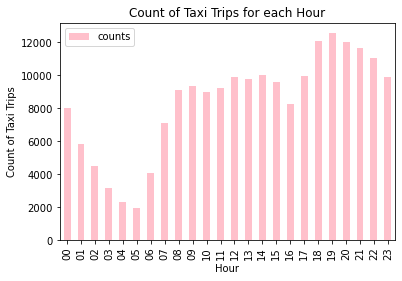

In [49]:
histogram_for_taxi_trip()

### Question 2
Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.

Here we use a line chart to visualize this data.

In [50]:
def ave_distance_month() -> None:
    
    # define new sql query statements
    taxi_STMT = """
    SELECT strftime ("%Y-%m",pickup_datetime) AS year_month, SUM(distance) AS distance
    FROM taxi_trip
    GROUP BY year_month;
    """
    
    uber_STMT = """
    SELECT strftime ("%Y-%m",pickup_datetime) AS year_month, SUM(distance) AS distance
    FROM uber_trip
    GROUP BY year_month;
    """
    
    both_STMT = """
    WITH hired_trip AS (
    SELECT strftime ("%Y-%m",pickup_datetime) AS year_month, SUM(distance) AS distance
    FROM taxi_trip
    GROUP BY year_month
    UNION ALL
    SELECT strftime ("%Y-%m",pickup_datetime) AS year_month, SUM(distance) AS distance
    FROM uber_trip
    GROUP BY year_month)
    
    SELECT year_month, SUM(distance) AS distance
    FROM hired_trip
    GROUP BY year_month;
    """
    
    # execute the queries
    taxi_data = pd.read_sql_query(taxi_STMT, engine)
    uber_data = pd.read_sql_query(uber_STMT, engine)
    both_data = pd.read_sql_query(both_STMT, engine)
    
    taxi_data["year_month"] = pd.to_datetime(taxi_data["year_month"], format='%Y-%m')
    uber_data["year_month"] = pd.to_datetime(uber_data["year_month"], format='%Y-%m')
    both_data["year_month"] = pd.to_datetime(both_data["year_month"], format='%Y-%m')
    
    # calculate mean, std and dof
    taxi_data = taxi_data["distance"].groupby(taxi_data["year_month"].dt.month).agg(["mean","sem","count"])
    taxi_data["dof"] = taxi_data["count"] - 1
    uber_data = uber_data["distance"].groupby(uber_data["year_month"].dt.month).agg(["mean","sem","count"])
    uber_data["dof"] = uber_data["count"] - 1
    both_data = both_data["distance"].groupby(both_data["year_month"].dt.month).agg(["mean","sem","count"])
    both_data["dof"] = both_data["count"] - 1
    
    # calculate 90% confidence interval
    taxi_low_CI, taxi_high_CI = stats.t.interval(0.90, taxi_data["dof"], loc = taxi_data["mean"], scale = taxi_data["sem"])
    uber_low_CI, uber_high_CI = stats.t.interval(0.90, uber_data["dof"], loc = uber_data["mean"], scale = uber_data["sem"])
    both_low_CI, both_high_CI = stats.t.interval(0.90, both_data["dof"], loc = both_data["mean"], scale = both_data["sem"])
    
    # plot the line chart
    plt.plot(taxi_data.index, taxi_data["mean"], color="green", label="Taxi")
    plt.fill_between(taxi_data.index, taxi_low_CI, taxi_high_CI, color="green", alpha=0.2)
    plt.plot(uber_data.index, uber_data["mean"], color="red", label="Uber")
    plt.fill_between(uber_data.index, uber_low_CI, uber_high_CI, color="red", alpha=0.2)
    plt.plot(both_data.index, both_data["mean"], color="orange", label="Both Taxi and Uber")
    plt.fill_between(both_data.index, both_low_CI, both_high_CI, color="orange", alpha=0.2)
    plt.title("Average Distance Traveled per Month")
    plt.xlabel("Month")
    plt.ylabel("Average Distance")
    plt.legend()
    plt.show()

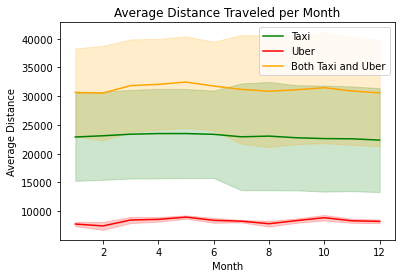

In [51]:
ave_distance_month()

### Question 3
Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR. Create a visualization that compares what day of the week was most popular for drop offs for each airport.

Here we use a multi-bar chart to visualize the data.

In [52]:
def day_airport_dropoff() -> None:
    
    JFK_COORD = [-73.812475,40.665539,-73.768101,40.640612,"JFK"]
    EWR_COORD = [-74.192090,40.698079,-74.176340,40.685526,"EWR"]
    LGA_COORD = [-73.889923,40.774897,-73.858080,40.765477,"LGA"]
    
    data = []
    # get data from dataset
    for box in [EWR_COORD, JFK_COORD, LGA_COORD]:
        query_STMT = f"""
        WITH hired_trip AS (
        SELECT pickup_datetime, dropoff_longitude, dropoff_latitude
        FROM taxi_trip
        UNION ALL
        SELECT pickup_datetime, dropoff_longitude, dropoff_latitude
        FROM uber_trip)
        
        SELECT strftime ("%w",pickup_datetime) AS day, COUNT(*) AS {box[4]}
        FROM hired_trip
        WHERE dropoff_longitude BETWEEN {box[0]} AND {box[2]} AND dropoff_latitude BETWEEN {box[3]} AND {box[1]}
        GROUP BY day;
        """
        data.append(pd.read_sql_query(query_STMT, engine))
    
    # put all data in the same dataframe
    data[0]["JFK"] = data[1]["JFK"]
    data[0]["LGA"] = data[2]["LGA"]
    data = data[0].T
    
    # plot the multi-bar chart
    labels = data.index[1:4]
    fig, ax = plt.subplots()
    x = np.arange(3)
    width = 0.12
    rect0 = ax.bar(x, data[0][1:4].astype("int64"), width, color = "maroon")
    rect1 = ax.bar(x+width, data[1][1:4].astype("int64"), width, color = "firebrick")
    rect2 = ax.bar(x+2*width, data[2][1:4].astype("int64"), width, color = "indianred")
    rect3 = ax.bar(x+3*width, data[3][1:4].astype("int64"), width, color = "lightsalmon", tick_label = ["EWR", "JFK", "LGA"])
    rect4 = ax.bar(x+4*width, data[4][1:4].astype("int64"), width, color = "coral")
    rect5 = ax.bar(x+5*width, data[5][1:4].astype("int64"), width, color = "tomato")
    rect6 = ax.bar(x+6*width, data[6][1:4].astype("int64"), width, color = "orangered")
    
    ax.set_ylabel("Number of trips")
    ax.legend((rect0, rect1, rect2, rect3, rect4, rect5, rect6),\
              ("Sunday", "Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday"))
    plt.title("Number of dropoffs at each airport")
    plt.show()

In this chart, we grouped the data for each airport together to compare which day is the most popular for them respectively. Each airport has 7 bars denoting the number of trips to that airport.

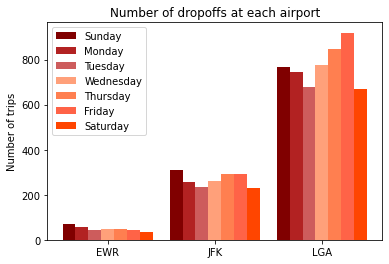

In [53]:
day_airport_dropoff()

### Question 4
Create a heatmap of all hired trips over a map of the area.

Here we uses KeplerGl package to plot the heatmap.

In [54]:
def heatmap_hired_trips() -> kg.keplergl.KeplerGl:
    query_STMT = f"""
    WITH hired_trip AS (
    SELECT pickup_longitude, pickup_latitude
    FROM taxi_trip
    UNION ALL
    SELECT pickup_longitude, pickup_latitude
    FROM uber_trip)

    SELECT pickup_longitude AS longitude, pickup_latitude AS latitude
    FROM hired_trip;
    """
    query_data = pd.read_sql_query(query_STMT, engine)
    heat_map = kg.KeplerGl()
    heat_map.add_data(data = query_data, name = "pickup")
    
    # we tried to directly render the map in the function but it did not work, so we chose to return the map.
    return heat_map

In the next cell, we call the function `heatmap_hired_trips()` and use the function in the keplergl map to change the scatter points into clusters, choose the color and show the legend.

In [55]:
heat_map = heatmap_hired_trips()
heat_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'pickup': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …

### Question 5
Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides.

In [56]:
def scatter_taxi_tip_distance() -> None:
    query_STMT = """
    SELECT tip_amount,distance
    FROM taxi_trip;
    """
    
    data = pd.read_sql_query(query_STMT, engine)
    # remove some outliers
    data = data[(data["tip_amount"]<=20) & (data["tip_amount"]>0)]
    
    # sample the data to make the plot clearer
    data = data.sample(10000)
    
    plt.scatter(data["distance"],data["tip_amount"],s = 5, color = "firebrick")
    plt.title("Tip vs Distance")
    plt.xlabel("Distance")
    plt.ylabel("Tip")

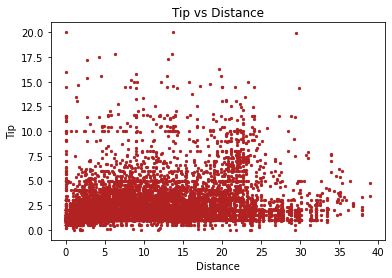

In [57]:
scatter_taxi_tip_distance()

### Question 6
Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides.

In [58]:
def scatter_taxi_tip_precipitation() -> None:
    query_STMT_taxi = """
    SELECT strftime("%Y-%m-%d %H",pickup_datetime) AS time, tip_amount
    FROM taxi_trip;
    """
    query_STMT_weather ="""
    SELECT strftime("%Y-%m-%d %H",DATE) AS time, HourlyPrecipitation AS precipitation
    FROM hourly_weather;
    """
    data_taxi = pd.read_sql_query(query_STMT_taxi, engine)
    data_weather = pd.read_sql_query(query_STMT_weather, engine)
    
    data_taxi["time"] = pd.to_datetime(data_taxi["time"], format='%Y-%m-%d %H')
    data_weather["time"] = pd.to_datetime(data_weather["time"], format='%Y-%m-%d %H')
    
    data = pd.merge(data_taxi, data_weather, on="time")
    # remove some outliers
    data = data[(data["tip_amount"]>0) & (data["tip_amount"]<=20)]
    
    # sample the data to make the plot clearer
    data = data.sample(50000)
    
    plt.scatter(data["precipitation"],data["tip_amount"],s = 8, color = "firebrick")
    plt.title("Tip vs Precipitation")
    plt.xlabel("Precipitation")
    plt.ylabel("Tip")

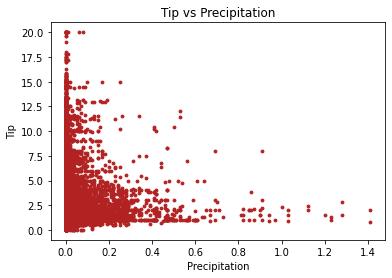

In [59]:
scatter_taxi_tip_precipitation()

## Extra
### Sun_data query
For everyday in June 2013 that has a record of sunrise and sunset, get the number of Yellow Taxi rides between sunrise and sunset.

In [60]:
# define the query_file name for this question
query_file = "June_2013_rides_between_sunrise_sunset.sql"

In [61]:
# write the query
QUERY_STMT = """
SELECT strftime("%Y-%m-%d",pickup_datetime) AS date, COUNT(*) AS counts
FROM taxi_trip JOIN daily_sun ON strftime("%Y-%m-%d",DATE) = strftime("%Y-%m-%d",pickup_datetime)
WHERE strftime("%H:%M",pickup_datetime) BETWEEN ("0"||SUBSTRING(Sunrise,1,1)||":"||SUBSTRING(Sunrise,2,2)) AND (SUBSTRING(Sunset,1,2)||":"||SUBSTRING(Sunset,3,2))
AND date BETWEEN "2013-06-01" AND "2013-07-01"
GROUP BY date;
"""

In [62]:
# execute the query
engine.execute(QUERY_STMT).fetchall()

[('2013-06-01', 51),
 ('2013-06-02', 53),
 ('2013-06-03', 53),
 ('2013-06-04', 57),
 ('2013-06-05', 59),
 ('2013-06-06', 54),
 ('2013-06-07', 65),
 ('2013-06-08', 43),
 ('2013-06-09', 31),
 ('2013-06-10', 47),
 ('2013-06-11', 54),
 ('2013-06-12', 52),
 ('2013-06-13', 63),
 ('2013-06-14', 45),
 ('2013-06-15', 46),
 ('2013-06-16', 34),
 ('2013-06-17', 69),
 ('2013-06-18', 43),
 ('2013-06-19', 64),
 ('2013-06-20', 53),
 ('2013-06-21', 58),
 ('2013-06-22', 49),
 ('2013-06-23', 40),
 ('2013-06-24', 53),
 ('2013-06-25', 57),
 ('2013-06-26', 68),
 ('2013-06-27', 49),
 ('2013-06-28', 54),
 ('2013-06-29', 41),
 ('2013-06-30', 36)]

In [63]:
# write the query to file
query_to_file(QUERY_STMT, query_file)